In [11]:
from datetime import time
from pathlib import Path

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import sys
sys.path.append('..')

In [2]:
from tools.optimization import create_multi_objective_optimizer, run_multi_objective_optimization,filter_inf_results, plot_simple_event_convergence, filter_inf_results
from tools.optimization import run_multi_event_optimization, plot_single_event_comparison, plot_multi_event_convergence, plot_single_event_convergence
from tools.simulation import setup_event_simulator
from tools.visualization import create_detector_comparison_display

In [3]:
from tools.geometry import generate_detector
import jax.numpy as jnp
json_filename='../config/IWCD_geom_config.json'
detector = generate_detector(json_filename)
detector_points = jnp.array(detector.all_points)

In [4]:
import pickle

with open('output/optimization/optimization_results.pkl', 'rb') as f:
    loaded_results = pickle.load(f)
results = filter_inf_results(loaded_results)

Filtered out 1 events with inf values.
Infinity breakdown: 1 energy-only, 0 spatial-only, 0 both components
Remaining events: 19


In [5]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 8

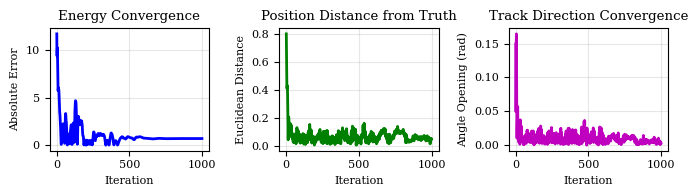


=== Event 0 Final Results ===
Energy Error: 0.6969
Position Distance: 0.0475
Angle Opening: 0.0033 rad (0.19°)


(Array(0.69692993, dtype=float32),
 np.float32(0.047510784),
 np.float64(0.003341874358778201))

In [6]:
plot_simple_event_convergence(0, results, save_path=None, figsize=(7, 2))

In [7]:
import os
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

def create_optimization_video_frames(
    results,
    event_idx,
    detector_points,
    json_filename=json_filename,
    Nphot=1_000_000,
    temperature=0.05,
    K=2,
    iteration_step=100,
    use_time=False,
    max_iteration=None,
    fixed_colorbar=True,
    colorbar_margin=30
):
    """
    Create frames for optimization visualization video.
    
    Parameters:
    -----------
    results : dict
        Output from run_multi_event_optimization
    event_idx : int
        Index of the event to visualize
    detector_points : array
        Detector points for simulation
    json_filename : str
        Path to detector configuration
    Nphot : int
        Number of photons for simulation
    temperature : float
        Temperature parameter for simulation
    K : int
        K parameter for simulation
    iteration_step : int
        Save frame every N iterations
    use_time : bool
        If True, visualize time differences; if False, charge differences
    max_iteration : int, optional
        Maximum iteration to process. If None, process all iterations
    fixed_colorbar : bool
        If True, use fixed colorbar range across all frames based on first frame
    colorbar_margin : float
        Percentage margin to add to first frame's max value for colorbar range
    
    Returns:
    --------
    str
        Path to the folder containing the generated frames
    """
    import os
    import jax
    import jax.numpy as jnp
    import matplotlib.pyplot as plt
    
    # Setup event simulator
    simulate_event = setup_event_simulator(
        json_filename, Nphot, temperature=temperature, K=K, is_calibration=False
    )
    
    # Fixed detector params (same as in optimization)
    detector_params = (
        jnp.array(4.),         # scatter_length
        jnp.array(0.2),        # reflection_rate
        jnp.array(6.),         # absorption_length
        jnp.array(0.001)       # gumbel_softmax_temp
    )
    
    # Fixed JAX key
    event_key = jax.random.PRNGKey(42)
    
    # Extract data for this event
    true_params = results['true_params'][event_idx]
    param_history = results['param_histories'][event_idx]
    
    # Simulate true event once
    print(f"Simulating true event for event {event_idx}...")
    true_event_data = simulate_event(true_params, detector_params, event_key)
    
    # Setup display function
    display_function = create_detector_comparison_display(
        json_filename=json_filename, 
        sparse=False
    )
    
    # Calculate fixed colorbar range if requested
    colorbar_range = None
    if fixed_colorbar:
        print("Calculating colorbar range from first frame...")
        colorbar_range = calculate_colorbar_range_from_first_frame(
            results=results,
            event_idx=event_idx,
            detector_points=detector_points,
            json_filename=json_filename,
            Nphot=Nphot,
            temperature=temperature,
            K=K,
            use_time=use_time,
            margin_percent=colorbar_margin
        )
    
    # Create folder structure
    frame_type = 'time' if use_time else 'charge'
    folder_path = f'optimization_frames/event_{event_idx}/{frame_type}'
    os.makedirs(folder_path, exist_ok=True)
    
    # Get total iterations from parameter history
    total_iterations = len(param_history['energy'])  # Get length from any parameter
    
    # Apply max_iteration limit if specified
    if max_iteration is not None:
        end_iteration = min(max_iteration, total_iterations)
    else:
        end_iteration = total_iterations
    
    print(f"Creating {frame_type} frames for event {event_idx}...")
    print(f"Total iterations available: {total_iterations}")
    print(f"Processing iterations: 0 to {end_iteration}")
    print(f"Saving every {iteration_step} iterations")
    
    # Generate frames
    frame_count = 0
    
    for iteration in range(0, end_iteration, iteration_step):
        # Get predicted params at this iteration by reconstructing from history
        predicted_energy = param_history['energy'][iteration]
        predicted_position = jnp.array([
            param_history['position_x'][iteration],
            param_history['position_y'][iteration], 
            param_history['position_z'][iteration]
        ])
        predicted_angles = jnp.array([
            param_history['theta'][iteration],
            param_history['phi'][iteration]
        ])
        predicted_params = (predicted_energy, predicted_position, predicted_angles)
        
        # Simulate predicted event
        predicted_event_data = simulate_event(predicted_params, detector_params, event_key)
        
        # Create filename
        filename = os.path.join(folder_path, f'frame_{frame_count:04d}_iter_{iteration:04d}.png')
        
        # Plot comparison
        display_function(
            true_data=true_event_data,
            sim_data=predicted_event_data,
            file_name=filename,
            plot_time=use_time,
            align_time=use_time,  # Align time if plotting time
            colorbar_range=colorbar_range  # Use fixed range if calculated
        )
        
        # Close the figure to prevent memory issues
        plt.close('all')
        
        frame_count += 1
        
        if iteration % (iteration_step * 5) == 0:  # Progress update every 5 frames
            print(f"  Generated frame {frame_count} (iteration {iteration})")
    
    print(f"Completed! Generated {frame_count} frames in {folder_path}")
    print(f"Frame files: frame_XXXX_iter_YYYY.png")
    print(f"  where XXXX is frame number and YYYY is iteration number")
    
    return folder_path


def clean_optimization_frames(event_idx=None, frame_type=None, base_folder='optimization_frames'):
    """
    Clean optimization frames from the folder structure.
    
    Parameters:
    -----------
    event_idx : int, optional
        Specific event index to clean. If None, clean all events
    frame_type : str, optional
        Specific frame type ('time' or 'charge') to clean. If None, clean both
    base_folder : str
        Base folder containing the optimization frames
    
    Returns:
    --------
    int
        Number of files deleted
    """
    import os
    import shutil
    
    if not os.path.exists(base_folder):
        print(f"Base folder {base_folder} does not exist.")
        return 0
    
    files_deleted = 0
    
    if event_idx is not None:
        # Clean specific event
        event_folder = os.path.join(base_folder, f'event_{event_idx}')
        if not os.path.exists(event_folder):
            print(f"Event folder {event_folder} does not exist.")
            return 0
            
        if frame_type is not None:
            # Clean specific frame type for specific event
            frame_folder = os.path.join(event_folder, frame_type)
            if os.path.exists(frame_folder):
                files_in_folder = len([f for f in os.listdir(frame_folder) if f.endswith('.png')])
                shutil.rmtree(frame_folder)
                files_deleted += files_in_folder
                print(f"Deleted {files_in_folder} {frame_type} frames for event {event_idx}")
            else:
                print(f"Frame type folder {frame_folder} does not exist.")
        else:
            # Clean all frame types for specific event
            for ftype in ['time', 'charge']:
                frame_folder = os.path.join(event_folder, ftype)
                if os.path.exists(frame_folder):
                    files_in_folder = len([f for f in os.listdir(frame_folder) if f.endswith('.png')])
                    shutil.rmtree(frame_folder)
                    files_deleted += files_in_folder
                    print(f"Deleted {files_in_folder} {ftype} frames for event {event_idx}")
            
            # Remove event folder if empty
            if os.path.exists(event_folder) and not os.listdir(event_folder):
                os.rmdir(event_folder)
                print(f"Removed empty event folder: event_{event_idx}")
    else:
        # Clean all events
        if frame_type is not None:
            # Clean specific frame type for all events
            for item in os.listdir(base_folder):
                if item.startswith('event_') and os.path.isdir(os.path.join(base_folder, item)):
                    frame_folder = os.path.join(base_folder, item, frame_type)
                    if os.path.exists(frame_folder):
                        files_in_folder = len([f for f in os.listdir(frame_folder) if f.endswith('.png')])
                        shutil.rmtree(frame_folder)
                        files_deleted += files_in_folder
                        print(f"Deleted {files_in_folder} {frame_type} frames for {item}")
        else:
            # Clean everything
            files_in_folder = 0
            for root, dirs, files in os.walk(base_folder):
                files_in_folder += len([f for f in files if f.endswith('.png')])
            
            shutil.rmtree(base_folder)
            files_deleted = files_in_folder
            print(f"Deleted entire optimization_frames folder with {files_deleted} frames")
    
    return files_deleted

def calculate_colorbar_range_from_first_frame(
    results,
    event_idx,
    detector_points,
    json_filename='../config/IWCD_geom_config.json',
    Nphot=1_000_000,
    temperature=0.05,
    K=2,
    use_time=False,
    margin_percent=30
):
    """
    Calculate the colorbar range from the first frame to use for all subsequent frames.
    
    Parameters:
    -----------
    results : dict
        Output from run_multi_event_optimization
    event_idx : int
        Index of the event to analyze
    detector_points : array
        Detector points for simulation
    json_filename : str
        Path to detector configuration
    Nphot : int
        Number of photons for simulation
    temperature : float
        Temperature parameter for simulation
    K : int
        K parameter for simulation  
    use_time : bool
        If True, calculate range for time differences; if False, for charge differences
    margin_percent : float
        Percentage margin to add to the maximum value
        
    Returns:
    --------
    float
        Colorbar range to use for all frames
    """
    import jax
    import jax.numpy as jnp
    import numpy as np
    
    # Setup event simulator
    simulate_event = setup_event_simulator(
        json_filename, Nphot, temperature=temperature, K=K, is_calibration=False
    )
    
    # Fixed detector params
    detector_params = (
        jnp.array(4.),         # scatter_length
        jnp.array(0.2),        # reflection_rate
        jnp.array(6.),         # absorption_length
        jnp.array(0.001)       # gumbel_softmax_temp
    )
    
    # Fixed JAX key
    event_key = jax.random.PRNGKey(42)
    
    # Extract data for this event
    true_params = results['true_params'][event_idx]
    param_history = results['param_histories'][event_idx]
    
    # Simulate true event
    true_event_data = simulate_event(true_params, detector_params, event_key)
    
    # Get first frame parameters (iteration 0)
    first_energy = param_history['energy'][0]
    first_position = jnp.array([
        param_history['position_x'][0],
        param_history['position_y'][0], 
        param_history['position_z'][0]
    ])
    first_angles = jnp.array([
        param_history['theta'][0],
        param_history['phi'][0]
    ])
    first_params = (first_energy, first_position, first_angles)
    
    # Simulate first predicted event
    first_predicted_data = simulate_event(first_params, detector_params, event_key)
    
    # Calculate differences (same logic as in display function)
    true_charges, true_times = true_event_data
    sim_charges, sim_times = first_predicted_data
    
    if use_time:
        if True:  # align_time equivalent (you might want to make this a parameter)
            # Find active time points
            active_times_true = true_times > 0
            active_times_sim = sim_times > 0
            
            # Calculate means for active times
            true_time_mean = np.mean(true_times[active_times_true]) if np.any(active_times_true) else 0
            sim_time_mean = np.mean(sim_times[active_times_sim]) if np.any(active_times_sim) else 0
            
            # Subtract means from active times
            true_times_aligned = np.where(active_times_true, true_times - true_time_mean, 0)
            sim_times_aligned = np.where(active_times_sim, sim_times - sim_time_mean, 0)
            
            differences = sim_times_aligned - true_times_aligned
        else:
            differences = sim_times - true_times
    else:
        differences = sim_charges - true_charges
    
    # Calculate maximum absolute value
    max_abs_value = np.max(np.abs(differences))
    
    # Add margin
    colorbar_range = max_abs_value * (1 + margin_percent / 100)
    
    print(f"Calculated colorbar range from first frame:")
    print(f"  Max absolute difference: {max_abs_value:.2e}")
    print(f"  With {margin_percent}% margin: {colorbar_range:.2e}")
    print(f"  Type: {'Time' if use_time else 'Charge'} differences")
    
    return colorbar_range

In [8]:
clean_optimization_frames(event_idx=0, frame_type='charge')

import matplotlib
matplotlib.use('Agg') # to avoid getting all plots here!
folder_path = create_optimization_video_frames(
    results, 
    event_idx=0, 
    detector_points=detector_points,
    use_time=False,
    max_iteration=50,         # Only process first iterations
    iteration_step=1,         # Save only every iteration_step iterations
    fixed_colorbar=True,      # Default: True
    colorbar_margin=30        # Default: 30% margin
)

# # For time visualization  
# folder_path = create_optimization_video_frames(
#     results, 
#     event_idx=0, 
#     detector_points=detector_points,
#     use_time=True
# )

Base folder optimization_frames does not exist.
Simulating true event for event 0...
Calculating colorbar range from first frame...
Calculated colorbar range from first frame:
  Max absolute difference: 2.56e+01
  With 30% margin: 3.32e+01
  Type: Charge differences
Creating charge frames for event 0...
Total iterations available: 1000
Processing iterations: 0 to 50
Saving every 1 iterations
  Generated frame 1 (iteration 0)
  Generated frame 6 (iteration 5)
  Generated frame 11 (iteration 10)
  Generated frame 16 (iteration 15)
  Generated frame 21 (iteration 20)
  Generated frame 26 (iteration 25)
  Generated frame 31 (iteration 30)
  Generated frame 36 (iteration 35)
  Generated frame 41 (iteration 40)
  Generated frame 46 (iteration 45)
Completed! Generated 50 frames in optimization_frames/event_0/charge
Frame files: frame_XXXX_iter_YYYY.png
  where XXXX is frame number and YYYY is iteration number


In [12]:
import os
import subprocess
import numpy as np
from PIL import Image
import glob

def create_gif(
    frames_folder,
    output_path,
    total_duration=10.0,
    loop=0,
    optimize=True
):
    """
    Create animated GIF from frames.
    
    Parameters:
    -----------
    frames_folder : str
        Path to folder containing frame files
    output_path : str
        Output GIF file path (without extension)
    total_duration : float
        Total animation duration in seconds
    loop : int
        Number of loops (0 = infinite)
    optimize : bool
        Optimize GIF file size
    
    Returns:
    --------
    str
        Path to created GIF file
    """
    # Get frame files and sort them
    frame_files = glob.glob(os.path.join(frames_folder, 'frame_*.png'))
    frame_files.sort()
    
    if len(frame_files) == 0:
        raise ValueError(f"No frame files found in {frames_folder}")
    
    print(f"Found {len(frame_files)} frames")
    
    # Calculate frame duration
    frame_duration = int((total_duration / len(frame_files)) * 1000)  # milliseconds
    print(f"Frame duration: {frame_duration}ms each")
    
    # Load frames
    frames = []
    for frame_file in frame_files:
        img = Image.open(frame_file)
        frames.append(img)
    
    output_file = f"{output_path}.gif"
    
    # Create GIF
    frames[0].save(
        output_file,
        save_all=True,
        append_images=frames[1:],
        duration=frame_duration,
        loop=loop,
        optimize=optimize
    )
    
    print(f"GIF created successfully: {output_file}")
    return output_file

figures_dir = Path('figures')
figures_dir.mkdir(parents=True, exist_ok=True)
gif_file = create_gif(frames_folder='optimization_frames/event_0/charge', 
                      output_path="figures/optimization_event0_charge",
                      total_duration=8.0)
    
print(f"Created: {gif_file}")

Found 50 frames
Frame duration: 160ms each
GIF created successfully: figures/optimization_event0_charge.gif
Created: figures/optimization_event0_charge.gif
